Loading dataset


In [40]:
import pandas as pd
df = pd.read_csv('C:/Users/amuly/OneDrive/Desktop/sentiment analysis/output_file.csv')

In [55]:
pip install vaderSentiment

Dataset Exploration

In [41]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10397 entries, 0 to 10396
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Location          10397 non-null  object
 1   Number of review  10397 non-null  object
 2   Catagory          10397 non-null  object
 3   Review            10397 non-null  object
 4   Popular food      10397 non-null  object
 5   Online Order      10397 non-null  object
 6   ID                10397 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 568.7+ KB
None


In [42]:
print(df.columns)

Index(['Location', 'Number of review', 'Catagory', 'Review', 'Popular food',
       'Online Order', 'ID'],
      dtype='object')


In [43]:
print(df.tail())

                                      Location Number of review  \
10392                        The Sandwich Slut               No   
10393                        The Sandwich Slut               No   
10394                        The Sandwich Post               No   
10395                        The Sandwich Cafe               No   
10396  Lezzet Mediterranean Turkish Restaurant               No   

                     Catagory Review Popular food Online Order     ID  
10392  Mediterranean, Turkish     No           No           No  10393  
10393  Mediterranean, Turkish     No           No           No  10394  
10394  Mediterranean, Turkish     No           No           No  10395  
10395  Mediterranean, Turkish     No           No           No  10396  
10396  Mediterranean, Turkish     No           No           No  10397  


In [44]:
print(df.head())

                       Location Number of review              Catagory  \
0  All Stars Sports Bar & Grill               21              Bar, Pub   
1                    Olio e Piu            2,998        Italian, Pizza   
2        Boucherie West Village            1,465    French, Steakhouse   
3             Club A Steakhouse            4,413  American, Steakhouse   
4     Piccola Cucina Estiatorio              403     Italian, Sicilian   

                                              Review  Popular food  \
0       “The fries were terrific also, hot crisp...”         fries   
1            “I love the food and our server Maria!”  filet mignon   
2  “The filet mignon was impeccable and the musse...       lobster   
3  “My seafood cocktail had wonderful large lump ...  cacio e pepe   
4  “penne al pomodoro and bucatini cacio e pepe w...       mussels   

  Online Order  ID  
0          Yes   1  
1          Yes   2  
2          Yes   3  
3          Yes   4  
4          Yes   5  


In [45]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amuly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amuly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Text Preprocessing

Remove punctuation and lowercase , Remove stopwords

In [46]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Remove punctuation and convert text to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())  
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply preprocessing to the DataFrame
df['processed_text'] = df['Review'].apply(preprocess_text)


Sentiment Labeling

In [47]:
from nltk.sentiment import SentimentIntensityAnalyzer


# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def label_sentiment(text):
    score = sia.polarity_scores(text)['compound'] 
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['processed_text'].apply(label_sentiment)
print(df['sentiment'].value_counts())


sentiment
positive    5371
neutral     4737
negative     289
Name: count, dtype: int64


Feature Extraction

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_text'])
y = df['sentiment']


visualisation

1.word cloud

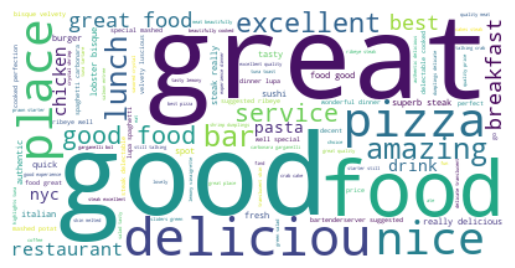

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['processed_text'])
wordcloud = WordCloud(background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


2.Sentiment visualisation

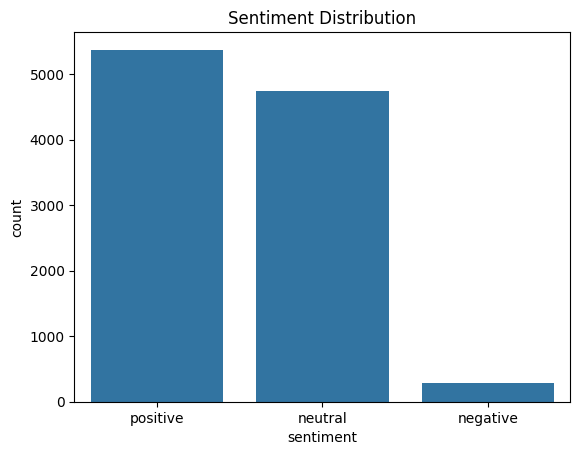

In [50]:
import seaborn as sns

sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()


Model Training

1. train test split

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2. Train a classifier


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9307692307692308
              precision    recall  f1-score   support

    negative       1.00      0.40      0.57        68
     neutral       0.88      1.00      0.93       943
    positive       0.99      0.91      0.95      1069

    accuracy                           0.93      2080
   macro avg       0.95      0.77      0.82      2080
weighted avg       0.94      0.93      0.93      2080



In [53]:
def filter_reviews_by_place(place_name):
    place_reviews = df[df['Location'].str.lower() == place_name.lower()]
    
    if place_reviews.empty:
        return "No reviews found for this place."  
    
    positive_reviews = place_reviews[place_reviews['sentiment'] == 'positive']
    negative_reviews = place_reviews[place_reviews['sentiment'] == 'negative']
    
    return positive_reviews.shape[0], negative_reviews.shape[0] 


result = filter_reviews_by_place("All Stars Sports Bar & Grill")

if isinstance(result, tuple):
    positive, negative = result
    print(f"Positive Reviews: {positive}, Negative Reviews: {negative}")
else:
    print(result)  


Positive Reviews: 29, Negative Reviews: 0


In [54]:
import joblib  
joblib.dump(model, 'sentiment_model.pkl')  

['sentiment_model.pkl']